# 10-Armed Testbed

* Problem: 10-Armed Testbed
* Reference: "Reinforcement Learning: An introduction (Second Edition) by Sutton, Barto"
* Section: 2.3, Pgs. 28, 29
* Reference Figure: Figure 2.2, Pg. 29

# Import required libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.special import softmax

from tqdm import tqdm
%matplotlib inline

# Define Function: action_sel

In [2]:
def action_sel(est_av, method = 'eps_greedy', eps = 0.1, ts = 1, act_count = [0], c = 1):
    """
    """
    
    if (method == 'eps_greedy'):
        max_av = np.max(est_av) # Current maximum of all estimated action values
        explore = np.random.choice([0, 1], p = [(1 - eps), eps]) # Choose whether to explore or exploit
        
        if (explore): # Non-greedy action
            at_values = np.arange(len(est_av)) # All actions possible for for this time step
        else: #  Take greedy action
            at_values = np.where(est_av == max_av)[0] # Only actions whose est_av = max_av are possible for this time step

        at = np.random.choice(at_values) # Choose action to take at timestep t randomly from at_values
        
    elif (method == 'ucb'):
        explore = 1
        act_count = act_count + 1e-9
        ucb_av = est_av + c * np.sqrt(np.log(ts) / act_count)
        at = np.argmax(ucb_av)
        
    return at, explore

# Define Function: run_agent

In [3]:
def run_agent(n_arms, num_timesteps, eps, true_av, update_method = 'sample_average', val_init = 'zeros', alpha = 0.1,\
             action_sel_method = 'eps_greedy', c = 1):
    '''
    Perform one run of the agent 
    Arguments:
        n_arms: Numbers of arms in the bandit
        num_timesteps: Number of timesteps for which the agent will be run
        eps: Epsilon value to use for the eps-greedy algorithm
        true_av: True action values of all actions for the current run
        update_method: Either 'sample_average' or 'constant_stepsize'
                       'Sample_average': Ref - 'A simple Bandit algorithm', Incremental implementation, Pg. 32 of RL_Sutton
                       'constant_stepsize': Ref - Eqn. (2.5), Pg. 32 of RL_Sutton
        val_init: Either 'zeros' or 'optim'.
                  'zeros': All action values initialized to zero
                  'optim': All action values initialized to +5 (Ref: Section 2.6 of RL_Sutton)
        alpha: Step-size parameter to use for 'constant_stepsize' method
        
    '''
    
    true_opt_act = np.argmax(true_av) # True optimal action
    if (val_init == 'zeros'):
        est_av = np.zeros(n_arms) # Q0(a) - Initialize all estimated action values to zeros
    elif (val_init == 'optim'):
        est_av = np.ones(n_arms) * 5.0 # Q0(a) - Initialize all estimated action values to +5
    act_count = np.zeros(n_arms) # N(a) - Number of times each action has been selected so far
    explore_count = 0 # Number of times agent has explored during the run
    r = [] # Placeholder to store rewards at all timesteps for current run
    opt_act_flags = [] # Placeholder to flag if action at each time step was the true optimal action
    
    # Run through all timesteps for current bandit problem
    for t in range(num_timesteps):
        at, explore = action_sel(est_av, method = action_sel_method, eps = eps, ts = (t + 1), act_count = act_count, c = c)
        if (explore):
            explore_count += 1 # Increment explore_count
        
        opt_act_flags.append(int(at == true_opt_act)) # Update optimal action flag

        # Reward for current time step will be sampled from a normal distribution with
        # mean = true action value of the chosen action (Q*(at)) and standard deviation = 1
        mean_rt = true_av[at]
        r.append(np.random.normal(mean_rt, 1)) # Generate reward for current time step
        
        act_count[at] += 1 # Increment action count for current action
        if (update_method == 'sample_average'):
            est_av[at] = est_av[at] + (r[t] - est_av[at]) / act_count[at] # Update action value of current action 
                                                                          # based on sample-average method
        elif (update_method == 'constant_stepsize'):
            est_av[at] = est_av[at] +  alpha * (r[t] - est_av[at]) # Update action value of current action
                                                                   # assuming constant step-size
            
    return r, opt_act_flags, explore_count

# Execute 10-armed Testbed

Ref: Figure 2.2, Pg. 29 of RL_Sutton

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:27<00:00,  4.47it/s]


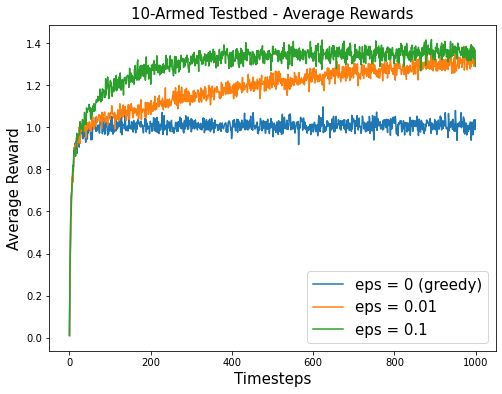

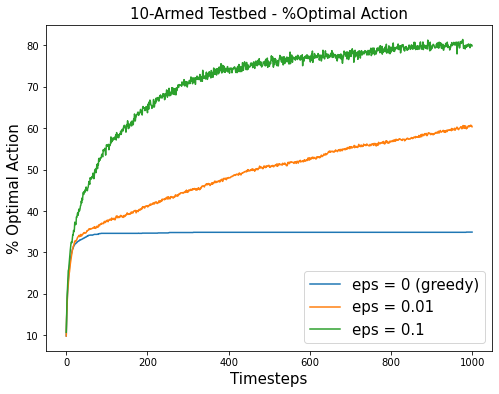

In [26]:
n_arms = 10 # Number of arms in the bandit
mean_tr_av = 0 # Mean of normal distribution from which true action values are sampled
std_tr_av = 1 # Standard deviation of normal distribution from which true action values are sampled
num_runs = 2000 # Number of independent runs (independent bandit problems)
num_timesteps = 1000 # Number of time steps for each run is executed
eps = [0.0, 0.01, 0.1] # epsilon value to use for epsilon-greedy algorithm
num_agents = len(eps) # Number of independent agents
update_method = 'sample_average' # Method used to update action values at each time step
val_init = 'zeros' # Initial value of estimated action values

true_max_av = np.zeros(num_runs) # Placeholder to store maximum of true action values
cum_reward = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative rewards 
                                                   # at each timestep for each agent
cum_opt_act_count = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative count of 
                                                          # optimal actions at each timestep for 
                                                          # each agent

# Iterate through all bandit problems
for run in tqdm(range(num_runs)): 
    
    # Sample true action values for all actions from a normal distribution with 
    # mean = mean_tr_av and standard deviation = std_tr_av
    #np.random.seed(1234)
    true_av = np.random.normal(mean_tr_av, std_tr_av, n_arms) # Q*(a)

    for agent in range(num_agents): # Loop through all agents
        # Run current agent for num_timesteps
        r, opt_act_flags, explore_count = run_agent(n_arms, num_timesteps, eps[agent], true_av)
        cum_reward[agent] += r
        cum_opt_act_count[agent] += opt_act_flags
        
avg_reward = cum_reward / num_runs # Averaged reward over all runs
avg_opt_act_percent = 100 * (cum_opt_act_count / num_runs) # Averaged optimal action count over 
                                                           # all runs

# Create legend for plots
agents = []
for eps_val in eps:
    if (eps_val == 0):
        agents.append("eps = 0 (greedy)")
    else:
        agents.append("eps = " + str(eps_val))
    
# Plot average rewards and %optimal action (Fig 2.2, Pg. 29 from RL_Sutton)
plt.figure(figsize = (8, 6))
plt.plot(avg_reward.T)
plt.title("10-Armed Testbed - Average Rewards", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("Average Reward", fontsize = 15)
plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

plt.figure(figsize = (8, 6))
plt.plot(avg_opt_act_percent.T)
plt.title("10-Armed Testbed - %Optimal Action", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("% Optimal Action", fontsize = 15)
plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

# Optimistic Initial Values

Ref: Figure 2.3, Pg. 34 of RL_Sutton

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:52<00:00,  6.84it/s]


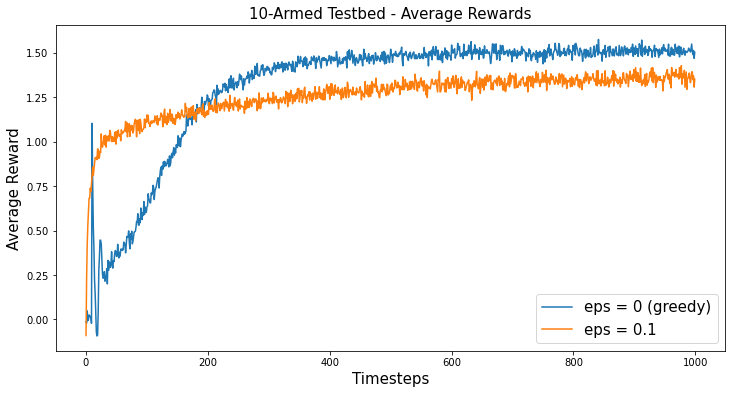

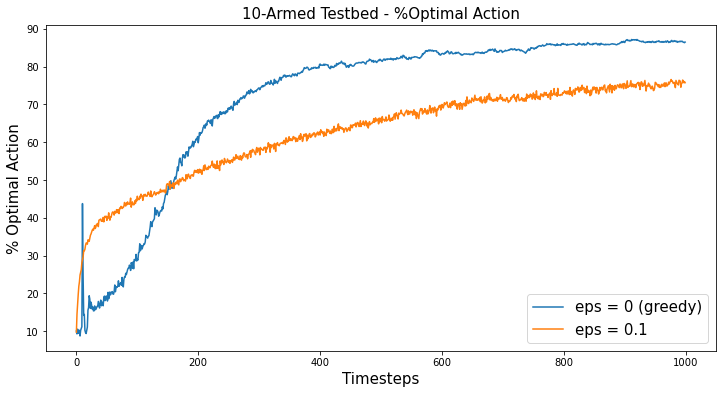

In [27]:
n_arms = 10 # Number of arms in the bandit
mean_tr_av = 0 # Mean of normal distribution from which true action values are sampled
std_tr_av = 1 # Standard deviation of normal distribution from which true action values are sampled
num_runs = 2000 # Number of independent runs (independent bandit problems)
num_timesteps = 1000 # Number of time steps for each run is executed
eps = [0.0, 0.1] # epsilon value to use for epsilon-greedy algorithm
num_agents = len(eps) # Number of independent agents
val_init = ['optim', 'zeros'] # Initial value of estimated action values

true_max_av = np.zeros(num_runs) # Placeholder to store maximum of true action values
cum_reward = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative rewards 
                                                   # at each timestep for each agent
cum_opt_act_count = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative count of 
                                                          # optimal actions at each timestep for 
                                                          # each agent

# Iterate through all bandit problems
for run in tqdm(range(num_runs)): 
    
    # Sample true action values for all actions from a normal distribution with 
    # mean = mean_tr_av and standard deviation = std_tr_av
    #np.random.seed(1234)
    true_av = np.random.normal(mean_tr_av, std_tr_av, n_arms) # Q*(a)

    for agent in range(num_agents): # Loop through all agents
        # Run current agent for num_timesteps
        r, opt_act_flags, explore_count = run_agent(n_arms, num_timesteps, eps[agent], true_av, 'constant_stepsize',\
                                                   val_init[agent])
        cum_reward[agent] += r
        cum_opt_act_count[agent] += opt_act_flags
        
avg_reward = cum_reward / num_runs # Averaged reward over all runs
avg_opt_act_percent = 100 * (cum_opt_act_count / num_runs) # Averaged optimal action count over 
                                                           # all runs

# Create legend for plots
agents = []
for eps_val in eps:
    if (eps_val == 0):
        agents.append("eps = 0 (greedy)")
    else:
        agents.append("eps = " + str(eps_val))
    
# Plot average rewards and %optimal action (Fig 2.3, Pg. 29 from RL_Sutton)
plt.figure(figsize = (12, 6))
plt.plot(avg_reward.T)
plt.title("10-Armed Testbed - Average Rewards", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("Average Reward", fontsize = 15)
plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(avg_opt_act_percent.T)
plt.title("10-Armed Testbed - %Optimal Action", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("% Optimal Action", fontsize = 15)
plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

# UCB Action Selection

Ref: Figure 2.4, Pg. 36 of RL_Sutton

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:12<00:00, 10.37it/s]


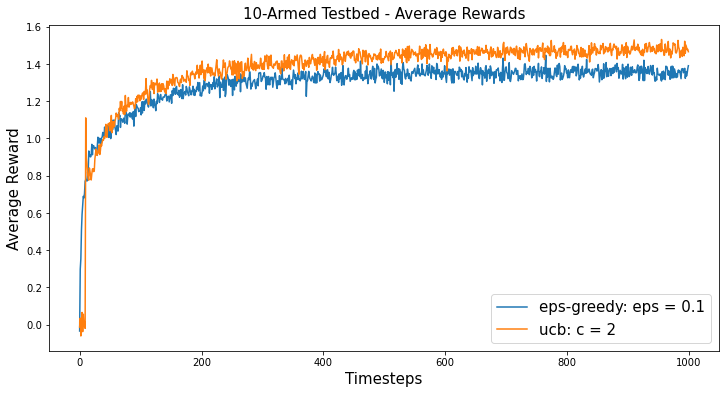

In [28]:
n_arms = 10 # Number of arms in the bandit
mean_tr_av = 0 # Mean of normal distribution from which true action values are sampled
std_tr_av = 1 # Standard deviation of normal distribution from which true action values are sampled
num_runs = 2000 # Number of independent runs (independent bandit problems)
num_timesteps = 1000 # Number of time steps for each run is executed
action_sel_method = ['eps_greedy', 'ucb'] # epsilon value to use for epsilon-greedy algorithm
num_agents = len(action_sel_method) # Number of independent agents
val_init = 'zeros' # Initial value of estimated action values
eps = 0.1
c = 2

true_max_av = np.zeros(num_runs) # Placeholder to store maximum of true action values
cum_reward = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative rewards 
                                                   # at each timestep for each agent
cum_opt_act_count = np.zeros((num_agents, num_timesteps)) # Placeholder to store cumulative count of 
                                                          # optimal actions at each timestep for 
                                                          # each agent

# Iterate through all bandit problems
for run in tqdm(range(num_runs)): 
    
    # Sample true action values for all actions from a normal distribution with 
    # mean = mean_tr_av and standard deviation = std_tr_av
    #np.random.seed(1234)
    true_av = np.random.normal(mean_tr_av, std_tr_av, n_arms) # Q*(a)

    for agent in range(num_agents): # Loop through all agents
        # Run current agent for num_timesteps
        r, opt_act_flags, explore_count = run_agent(n_arms, num_timesteps, eps, true_av, 'sample_average',\
                                                   val_init, 0.1, action_sel_method[agent], c)
        cum_reward[agent] += r
        cum_opt_act_count[agent] += opt_act_flags
        
avg_reward = cum_reward / num_runs # Averaged reward over all runs
avg_opt_act_percent = 100 * (cum_opt_act_count / num_runs) # Averaged optimal action count over 
                                                           # all runs

#Create legend for plots
agents = []
for act_method in action_sel_method:
    if (act_method == 'ucb'):
        agents.append("ucb: c = " + str(c))
    elif (act_method == 'eps_greedy'):
        agents.append("eps-greedy: eps = " + str(eps))
    
# Plot average rewards and %optimal action (Fig 2.3, Pg. 29 from RL_Sutton)
plt.figure(figsize = (12, 6))
plt.plot(avg_reward.T)
plt.title("10-Armed Testbed - Average Rewards", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("Average Reward", fontsize = 15)
plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

# Gradient Bandit Algorithm

In [54]:
x = [1001, 10, 100]
np.random.choice([0, 1, 2], p = softmax(x))
act_list = np.arange(10)
act_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


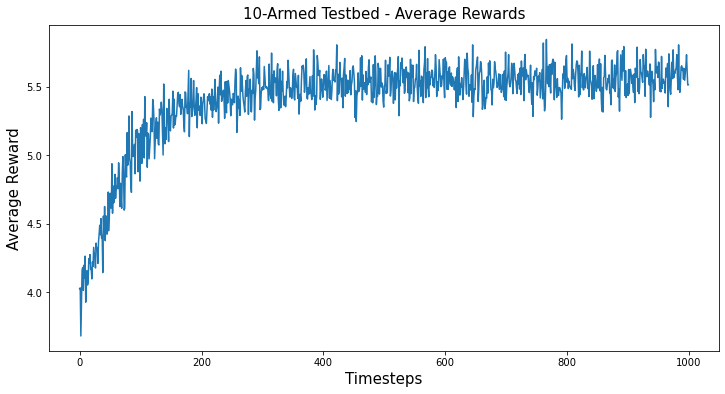

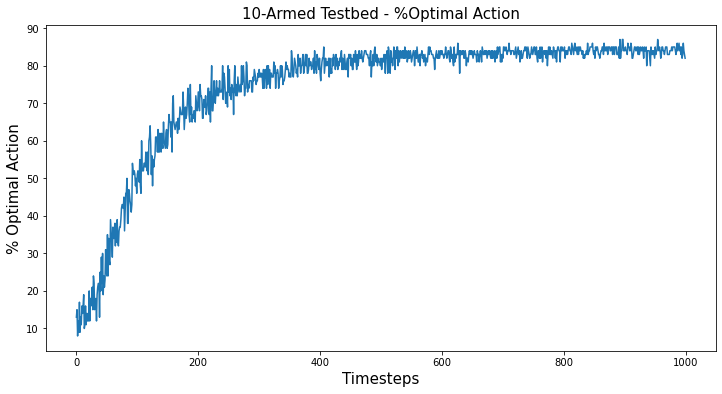

In [62]:
n_arms = 10 # Number of arms in the bandit
mean_tr_av = 4 # Mean of normal distribution from which true action values are sampled
std_tr_av = 1 # Standard deviation of normal distribution from which true action values are sampled
num_runs = 100 # Number of independent runs (independent bandit problems)
num_timesteps = 1000 # Number of time steps for each run is executed

act_list = np.arange(n_arms) # List of possible actions

cum_reward = np.zeros(num_timesteps)
cum_opt_act_count = np.zeros(num_timesteps)

for run in tqdm(range(num_runs)): 
    # Sample true action values for all actions from a normal distribution with 
    # mean = mean_tr_av and standard deviation = std_tr_av
    #np.random.seed(1234)
    true_av = np.random.normal(mean_tr_av, std_tr_av, n_arms) # Q*(a)
    true_opt_act = np.argmax(true_av) # True optimal action
    r_baseline = 0 # Average reward to use as baseline
    alpha = 0.1    
    r = []
    opt_act_flags = [] # Placeholder to flag if action at each time step was the true optimal action
    act_pref = np.zeros(n_arms) # Action preference array
    
    for t in range(num_timesteps):
        act_prob = softmax(act_pref)
        at = np.random.choice(act_list, p = act_prob)
        rt = np.random.normal(true_av[at], 1)
        r.append(rt)
        for act in act_list:
            if (act == at):
                act_pref[act] += alpha * (rt - r_baseline) * (1 - act_prob[act])
            else:
                act_pref[act] -= alpha * (rt - r_baseline) * act_prob[act]
        r_baseline += (rt - r_baseline)/(t + 1)
        opt_act_flags.append(int(at == true_opt_act)) # Update optimal action flag
    
    cum_reward += r
    cum_opt_act_count += opt_act_flags


avg_reward = cum_reward / num_runs # Averaged reward over all runs
avg_opt_act_percent = 100 * (cum_opt_act_count / num_runs) # Averaged optimal action count over 
                                                           # all runs    
    
# Plot average rewards and %optimal action (Fig 2.3, Pg. 29 from RL_Sutton)
plt.figure(figsize = (12, 6))
plt.plot(avg_reward.T)
plt.title("10-Armed Testbed - Average Rewards", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("Average Reward", fontsize = 15)
#plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(avg_opt_act_percent.T)
plt.title("10-Armed Testbed - %Optimal Action", fontsize = 15)
plt.xlabel("Timesteps", fontsize = 15)
plt.ylabel("% Optimal Action", fontsize = 15)
#plt.legend(agents, loc = 4, fontsize = 15)
plt.show()

In [61]:
r_baseline

4.860126574093778

In [ ]:
    true_opt_act = np.argmax(true_av) # True optimal action
    if (val_init == 'zeros'):
        est_av = np.zeros(n_arms) # Q0(a) - Initialize all estimated action values to zeros
    elif (val_init == 'optim'):
        est_av = np.ones(n_arms) * 5.0 # Q0(a) - Initialize all estimated action values to +5
    act_count = np.zeros(n_arms) # N(a) - Number of times each action has been selected so far
    explore_count = 0 # Number of times agent has explored during the run
    r = [] # Placeholder to store rewards at all timesteps for current run
    opt_act_flags = [] # Placeholder to flag if action at each time step was the true optimal action
    
    # Run through all timesteps for current bandit problem
    for t in range(num_timesteps):
        at, explore = action_sel(est_av, method = action_sel_method, eps = eps, ts = (t + 1), act_count = act_count, c = c)
        if (explore):
            explore_count += 1 # Increment explore_count
        
        opt_act_flags.append(int(at == true_opt_act)) # Update optimal action flag

        # Reward for current time step will be sampled from a normal distribution with
        # mean = true action value of the chosen action (Q*(at)) and standard deviation = 1
        mean_rt = true_av[at]
        r.append(np.random.normal(mean_rt, 1)) # Generate reward for current time step
        
        act_count[at] += 1 # Increment action count for current action
        if (update_method == 'sample_average'):
            est_av[at] = est_av[at] + (r[t] - est_av[at]) / act_count[at] # Update action value of current action 
                                                                          # based on sample-average method
        elif (update_method == 'constant_stepsize'):
            est_av[at] = est_av[at] +  alpha * (r[t] - est_av[at]) # Update action value of current action
                                                                   # assuming constant step-size
            
    return r, opt_act_flags, explore_count